In [ ]:
def func(x): 
    return model_gr.predict(x[None, :])
data = np.apply_along_axis(func, -1, X)

In [196]:
import numpy as np
import tensorflow as tf
path = "output/toy/search/gr/seed=0/run_20210804-141332/trial_0/model"
model_gr = tf.keras.models.load_model(path, compile=False)
path = "output/toy/search/no_gr/seed=0/run_20210804-142626/trial_0/model"
model_no_gr = tf.keras.models.load_model(path, compile=False)

path = "output/toy/search/gr_l1/seed=0/run_20210804-144939/trial_0/model"
model_gr_l1 = tf.keras.models.load_model(path, compile=False)
path = "output/toy/search/no_gr_l1/seed=0/run_20210804-144939/trial_0/model"
model_no_gr_l1 = tf.keras.models.load_model(path, compile=False)

In [233]:
models = {}

path = "output/toy/single/gr_tanh/run_20210805-093936/trial_1/model"
models['gr_tanh'] = tf.keras.models.load_model(path, compile=False)

path = "output/toy/single/no_gr_tanh/run_20210805-094013/trial_1/model"
models['no_gr_tanh'] = tf.keras.models.load_model(path, compile=False)

In [9]:
from tensorflow.keras.layers import Dropout, InputLayer, Dense

def sigmoid(x):
    return 1/(1 + np.exp(-x))  

def mu_evaluation(model, X):
    y = X
    qs = []
    mus = []
    for i, l in enumerate(model.layers):
        z = l(y)
        if isinstance(l, Dense):
            w, b = l.weights
            #print(w.shape, y.shape, l, i)
            z_pre_A = tf.einsum("io, ni -> no", w, y)
            z_pre_B = b
            z_pre = z_pre_A + z_pre_B
            z_2 = l.activation(z_pre)
            assert (np.abs(z_2 - z) < 0.01).all()
            q = z_pre
            q = sigmoid(q)
            # q = np.max(q, 0)
            # q = np.tanh(q)
            # q = np.abs(q)
            mu = np.mean(q)
            mus.append(mu)
            qs.append(q.flatten())
            #print(mu)
        elif isinstance(l, InputLayer):
            pass
        elif isinstance(l, Dropout):
            pass
        else:
            raise ValueError("Unsupported layer " + str(l))
        y = z
    mu = np.mean(np.concatenate(qs))
    return mu, mus

In [385]:
# make data

N = 100
M = N
d = 10
x_lin = np.linspace(-d, d, N)
y_lin = np.linspace(-d, d, M)
x_g, y_g = np.meshgrid(x_lin, y_lin)
X = np.stack([x_g, y_g], axis=-1)

def X_grid_to_columns(X):
    return X.reshape(-1, 2)

def X_columns_to_grid(X):
    return X.reshape(N, M, -1)

In [208]:
w.shape, y.shape

(TensorShape([30, 1]), TensorShape([2500, 1]))

In [257]:
y = np.array([0.1, 0.8, 0.4])
y = y > 0.5
y.astype(np.float)

array([0., 1., 0.])

In [363]:
def mu_evaluation(model, X, name='discrete', k=None):

    # Default parameter values
    if k is None:
        if name == 'bell':
            k = 4
        elif name == 'tanh':
            k = 5.0
        elif name == 'sigmoid':
            k = 5.0
        elif name == 'discrete':
            k = 0.5
        else:
            raise ValueError("Unknown name, ", name)

    if name == 'bell':
        def sat_func(q):
            q = 1 - np.exp(-k * q**2)
            return q
    elif name == 'tanh':
        def sat_func(q):
            q = np.tanh(k * q)
            # q = np.abs(q)
            return q
    elif name == 'sigmoid':
        def sat_func(q):
            q = sigmoid(k * q)
            return q
    elif name == 'discrete':
        def sat_func(q):
            q = np.abs(q)
            # q = np.array(q)
            q = (q > k)
            q = q.astype(np.float)
            return q

    y = X
    qs = []
    mus = []
    heights = []
    for i, l in enumerate(model.layers):
        z = l(y)
        if isinstance(l, Dense):
            w, b = l.weights
            # print("w: ", w.shape, "y: ", y.shape)
            z_pre_A = tf.einsum("io, ...ni -> ...no", w, y)
            z_pre_B = b
            z_pre = z_pre_A + z_pre_B
            z_2 = l.activation(z_pre)
            assert (np.abs(z_2 - z) < 0.01).all()
            # Measure the saturation of this neuron's input
            q = sat_func(z_pre)            
            # print("q: ", q.shape)
            # mu = np.einsum("no -> n", q) / q.size
            mu = np.mean(q, axis=-1) 
            # print("mu: ", mu.shape)
            #np.mean(q, axis=-1)
            mus.append(mu)
            heights.append(q.shape[-1])
            qs.append(q)
            #print(mu)
        elif isinstance(l, InputLayer):
            pass
        elif isinstance(l, Dropout):
            pass
        else:
            raise ValueError("Unsupported layer " + str(l))
        y = z
    mus = np.stack(mus, axis=0)
    heights = np.stack(heights)
    # print("heights: ", heights)
    # print("mus: ", mus.shape)
    mu_avg = np.mean(mus, axis=0)
    # print("mu_avg: ", mu_avg.shape)
    mu_wavg = np.average(mus, axis=0, weights=heights)
    # print("mu_wavg: ", mu_wavg.shape)
    return mu_avg, mu_wavg, mus

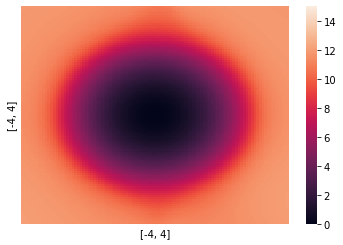

Text(50.0, 0.5, '[-4, 4]')

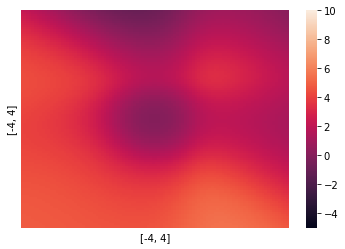

In [242]:
# plot predictions

XX = X_grid_to_columns(X)
YY = models['gr_tanh'].predict(XX)
Y = X_columns_to_grid(YY)

sns.heatmap(np.squeeze(Y), vmin=0.0, vmax=15.0, xticklabels=False, yticklabels=False)
plt.xlabel(f"[-{d}, {d}]") 
plt.ylabel(f"[-{d}, {d}]") 
plt.show()

XX = X_grid_to_columns(X)
YY = models['no_gr_tanh'].predict(XX)
Y = X_columns_to_grid(YY)

sns.heatmap(np.squeeze(Y), vmin=-5.0, vmax=10.0, xticklabels=False, yticklabels=False)
plt.xlabel(f"[-{d}, {d}]") 
plt.ylabel(f"[-{d}, {d}]")

In [327]:
# load models
path = f"output/toy/single/gr_tanh/run_20210805-093936/trial_{t}/model"
models['gr_tanh'] = tf.keras.models.load_model(path, compile=False)

path = f"output/toy/single/no_gr_tanh/run_20210805-094013/trial_{t}/model"
models['no_gr_tanh'] = tf.keras.models.load_model(path, compile=False)

XX = X_grid_to_columns(X)
YY = mu_evaluation(models['no_gr_tanh'], XX)[-1][l]
X_columns_to_grid(YY).shape

(100, 100, 1)

In [371]:
np.mean(mu_evaluation(models['gr_tanh'], XX)[-1], axis=0)

(320000,)

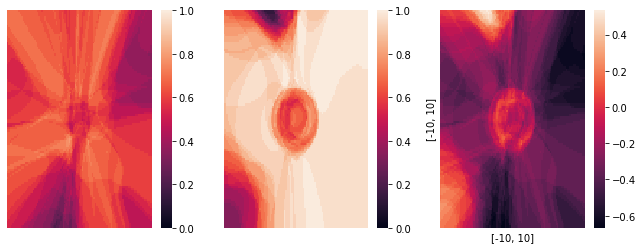

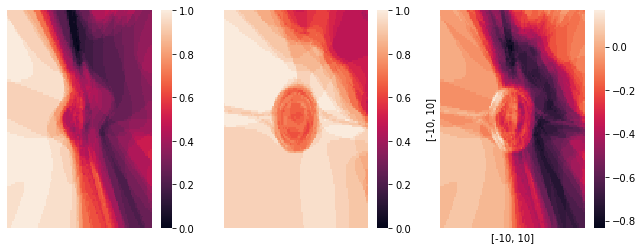

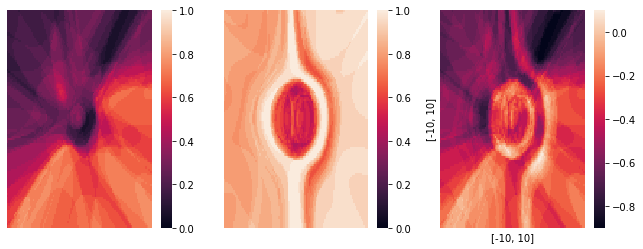

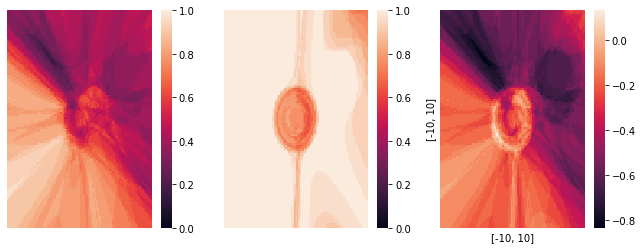

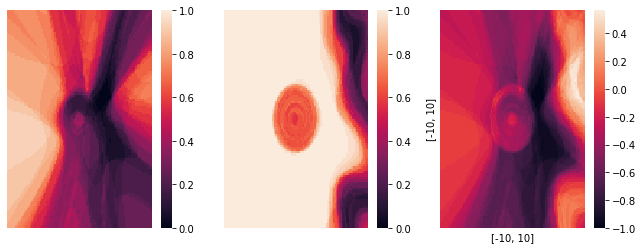

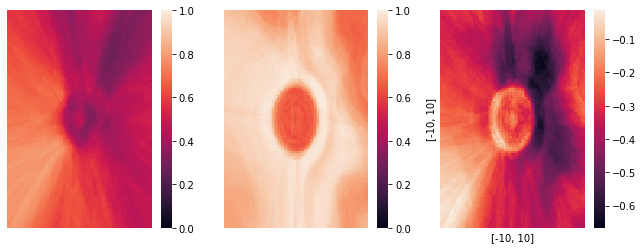

In [387]:
l = 0

Ys_gr = []
Ys_no_gr = []

vmin, vmax = 0.0, 1.0
# vmin, vmax = -1.0, 1.0

for t in range(5):

    # load models
    path = f"output/toy/single/gr_tanh/run_20210805-093936/trial_{t}/model"
    models['gr_tanh'] = tf.keras.models.load_model(path, compile=False)

    path = f"output/toy/single/no_gr_tanh/run_20210805-094013/trial_{t}/model"
    models['no_gr_tanh'] = tf.keras.models.load_model(path, compile=False)

    # plot models
    fig, (ax1, ax2, ax3) = plt.subplots(1,3)
    fig.set_size_inches(11, 4)

    XX = X_grid_to_columns(X)
    YY = mu_evaluation(models['no_gr_tanh'], XX)[-1][l]
    # YY = np.mean(mu_evaluation(models['no_gr_tanh'], XX)[-1][:-1], axis=0)
    Y = X_columns_to_grid(YY)
    Y1 = Y
    Ys_no_gr.append(Y)

    sns.heatmap(np.squeeze(Y), vmin=vmin, vmax=vmax, xticklabels=False, yticklabels=False, ax=ax1)
    plt.xlabel(f"[-{d}, {d}]")
    plt.ylabel(f"[-{d}, {d}]")

    XX = X_grid_to_columns(X)
    YY = mu_evaluation(models['gr_tanh'], XX)[-1][l]
    # YY = np.mean(mu_evaluation(models['gr_tanh'], XX)[-1][:-1], axis=0)
    Y = X_columns_to_grid(YY)
    Y2 = Y
    Ys_gr.append(Y)

    sns.heatmap(np.squeeze(Y), vmin=vmin, vmax=vmax, xticklabels=False, yticklabels=False, ax=ax2)
    plt.xlabel(f"[-{d}, {d}]")
    plt.ylabel(f"[-{d}, {d}]")

    sns.heatmap(np.squeeze(Y1-Y2), xticklabels=False, yticklabels=False, ax=ax3)
    plt.xlabel(f"[-{d}, {d}]")
    plt.ylabel(f"[-{d}, {d}]")
    plt.show()

# plot models
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_size_inches(11, 4)

Ys_no_gr = np.stack(Ys_no_gr, axis=0)
Ys_no_gr = np.mean(Ys_no_gr, axis=0)

sns.heatmap(np.squeeze(Ys_no_gr), vmin=vmin, vmax=vmax, xticklabels=False, yticklabels=False, ax=ax1)
plt.xlabel(f"[-{d}, {d}]")
plt.ylabel(f"[-{d}, {d}]")

Ys_gr = np.stack(Ys_gr, axis=0)
Ys_gr = np.mean(Ys_gr, axis=0)

sns.heatmap(np.squeeze(Ys_gr), vmin=vmin, vmax=vmax, xticklabels=False, yticklabels=False, ax=ax2)
plt.xlabel(f"[-{d}, {d}]")
plt.ylabel(f"[-{d}, {d}]")

sns.heatmap(np.squeeze(Ys_no_gr - Ys_gr), xticklabels=False, yticklabels=False, ax=ax3)
plt.xlabel(f"[-{d}, {d}]")
plt.ylabel(f"[-{d}, {d}]")
plt.show()

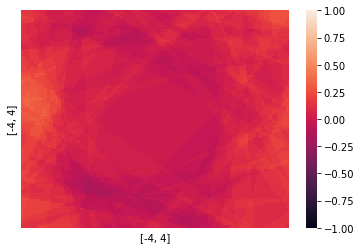

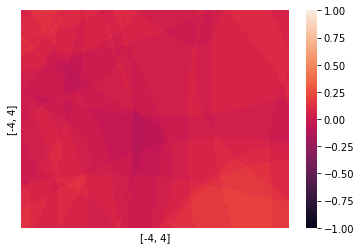

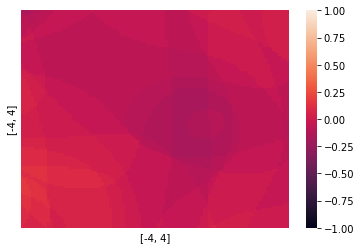

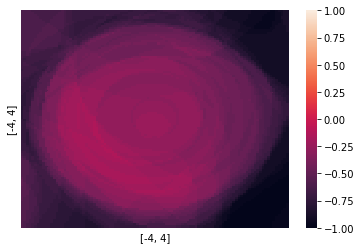

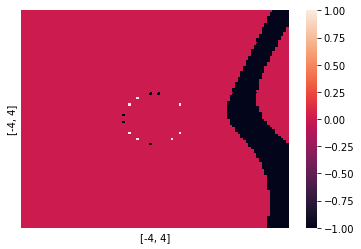

In [263]:
for l in range(5):
    # plot models
    XX = X_grid_to_columns(X)
    YY1 = mu_evaluation(models['no_gr_tanh'], XX)[-1][l]
    YY2 = mu_evaluation(models['gr_tanh'], XX)[-1][l]
    YY = YY1 - YY2
    Y = X_columns_to_grid(YY)

    sns.heatmap(np.squeeze(Y), vmin=-1.0, vmax=1.0, xticklabels=False, yticklabels=False)
    plt.xlabel(f"[-{d}, {d}]")
    plt.ylabel(f"[-{d}, {d}]")
    plt.show()

In [382]:
def in_ring(x, x_inner, x_outer):
    return ((-x_outer <= x) & (x <= -x_inner)) | ((x_inner <= x) & (x <= x_outer))

def ring(x_inner, x_outer):
    dx = 0.01
    nx = int( 2* x_outer / dx)
    x_lin = np.linspace(-x_outer, x_outer, nx)
    y_lin = np.linspace(-x_outer, x_outer, nx)
    x_g, y_g = np.meshgrid(x_lin, y_lin)
    x = x_g.flatten()
    y = y_g.flatten()
    idx = in_ring(x, x_inner, x_outer) | in_ring(y, x_inner, x_outer)
    X = np.stack([x,y], axis=-1)
    X = X[idx]
    return X

print("[-2,2]^2 \ [-1,-1]^2 ring")
XX = ring(1, 2)
XX.shape

thresh = 0.4

for t in range(5):

    # load models
    path = f"output/toy/single/gr_tanh/run_20210805-093936/trial_{t}/model"
    models['gr_tanh'] = tf.keras.models.load_model(path, compile=False)

    path = f"output/toy/single/no_gr_tanh/run_20210805-094013/trial_{t}/model"
    models['no_gr_tanh'] = tf.keras.models.load_model(path, compile=False)

    # YY = mu_evaluation(models['no_gr_tanh'], XX)[-1][0]
    YY = np.mean(mu_evaluation(models['no_gr_tanh'], XX)[-1][:-1], axis=0)
    YY = (YY > thresh)
    YY = YY.astype(np.float)
    YY = np.mean(YY)
    
    YY1 = YY

    # YY = mu_evaluation(models['gr_tanh'], XX)[-1][0]
    YY = np.mean(mu_evaluation(models['gr_tanh'], XX)[-1][:-1], axis=0)
    YY = (YY > thresh)
    YY = YY.astype(np.float)
    YY = np.mean(YY)

    YY2 = YY
    print(f"{YY1:.4f}\t{YY2:.4f}\t{YY1-YY2:.4f}")

print("[-1,1]^2 square")
XX = ring(0, 1)
XX.shape
for t in range(5):

    # load models
    path = f"output/toy/single/gr_tanh/run_20210805-093936/trial_{t}/model"
    models['gr_tanh'] = tf.keras.models.load_model(path, compile=False)

    path = f"output/toy/single/no_gr_tanh/run_20210805-094013/trial_{t}/model"
    models['no_gr_tanh'] = tf.keras.models.load_model(path, compile=False)

    YY = mu_evaluation(models['no_gr_tanh'], XX)[-1][0]
    YY = (YY > thresh)
    YY = YY.astype(np.float)
    YY = np.mean(YY)
    YY1 = YY

    YY = mu_evaluation(models['gr_tanh'], XX)[-1][0]
    YY = (YY > thresh)
    YY = YY.astype(np.float)
    YY = np.mean(YY)
    YY2 = YY
    print(f"{YY1:.4f}\t{YY2:.4f}\t{YY1-YY2:.4f}")

print("[-3,3]^2 \ [-1,-1]^2 ring")
XX = ring(1, 3)
XX.shape
for t in range(5):

    # load models
    path = f"output/toy/single/gr_tanh/run_20210805-093936/trial_{t}/model"
    models['gr_tanh'] = tf.keras.models.load_model(path, compile=False)

    path = f"output/toy/single/no_gr_tanh/run_20210805-094013/trial_{t}/model"
    models['no_gr_tanh'] = tf.keras.models.load_model(path, compile=False)

    YY = mu_evaluation(models['no_gr_tanh'], XX)[-1][0]
    YY = (YY > thresh)
    YY = YY.astype(np.float)
    YY = np.mean(YY)
    YY1 = YY

    YY = mu_evaluation(models['gr_tanh'], XX)[-1][0]
    YY = (YY > thresh)
    YY = YY.astype(np.float)
    YY = np.mean(YY)
    YY2 = YY
    print(f"{YY1:.4f}\t{YY2:.4f}\t{YY1-YY2:.4f}")

[-2,2]^2 \ [-1,-1]^2 ring
0.9311	1.0000	-0.0689
0.1043	0.4772	-0.3729
0.0000	0.0000	0.0000
0.5811	0.9657	-0.3846
0.0074	0.0001	0.0072
[-1,1]^2 square
0.0000	0.0000	0.0000
0.0000	0.0000	0.0000
0.0000	0.0000	0.0000
0.0000	0.0000	0.0000
0.0000	0.0000	0.0000
[-3,3]^2 \ [-1,-1]^2 ring
0.7081	0.5589	0.1492
0.5075	0.3841	0.1234
0.4322	0.0079	0.4244
0.6356	0.3361	0.2995
0.5256	0.1574	0.3682


In [296]:
print("[-4,4]^2 \ [-1,-1]^2 ring")
XX = ring(1, 4)
XX.shape
for t in range(5):

    # load models
    path = f"output/toy/single/gr_tanh/run_20210805-093936/trial_{t}/model"
    models['gr_tanh'] = tf.keras.models.load_model(path, compile=False)

    path = f"output/toy/single/no_gr_tanh/run_20210805-094013/trial_{t}/model"
    models['no_gr_tanh'] = tf.keras.models.load_model(path, compile=False)

    YY = mu_evaluation(models['no_gr_tanh'], XX)[-1][0]
    YY = np.mean(YY)
    YY1 = YY

    YY = mu_evaluation(models['gr_tanh'], XX)[-1][0]
    YY = np.mean(YY)
    YY2 = YY
    print(f"{YY1:.4f}\t{YY2:.4f}\t{YY1-YY2:.4f}")

[-4,4]^2 \ [-1,-1]^2 ring
0.6451	0.6236	0.0215
0.5591	0.5571	0.0020
0.5169	0.4045	0.1125
0.6261	0.5681	0.0579
0.5869	0.4883	0.0986


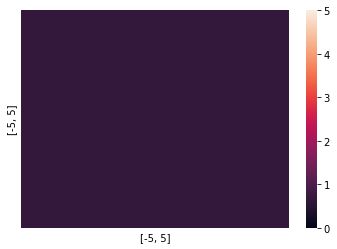

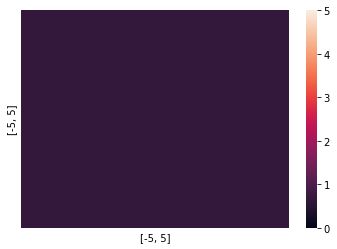

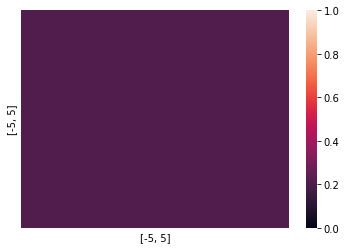

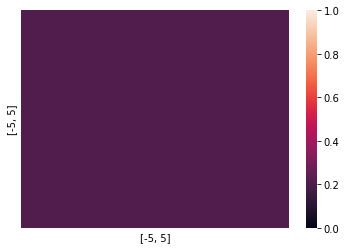

In [205]:
# plot predictions

XX = X_grid_to_columns(X)
YY = model_gr_l1.predict(XX)
Y = X_columns_to_grid(YY)

sns.heatmap(np.squeeze(Y), vmin=0.0, vmax=5.0, xticklabels=False, yticklabels=False)
plt.xlabel(f"[-{d}, {d}]") 
plt.ylabel(f"[-{d}, {d}]") 
plt.show()

XX = X_grid_to_columns(X)
YY = model_no_gr_l1.predict(XX)
Y = X_columns_to_grid(YY)

sns.heatmap(np.squeeze(Y), vmin=0.0, vmax=5.0, xticklabels=False, yticklabels=False)
plt.xlabel(f"[-{d}, {d}]") 
plt.ylabel(f"[-{d}, {d}]")
plt.show()

# plot models

XX = X_grid_to_columns(X)
YY = mu_evaluation(model_gr_l1, XX)[0]
Y = X_columns_to_grid(YY)

sns.heatmap(np.squeeze(Y), vmin=0.0, vmax=1.0, xticklabels=False, yticklabels=False)
plt.xlabel(f"[-{d}, {d}]")
plt.ylabel(f"[-{d}, {d}]")
plt.show()

# plot models
XX = X_grid_to_columns(X)
YY = mu_evaluation(model_no_gr_l1, XX)[0]
Y = X_columns_to_grid(YY)

sns.heatmap(np.squeeze(Y), vmin=0.0, vmax=1.0, xticklabels=False, yticklabels=False)
plt.xlabel(f"[-{d}, {d}]")
plt.ylabel(f"[-{d}, {d}]")
plt.show()

Text(50.0, 0.5, '[-2, 2]')

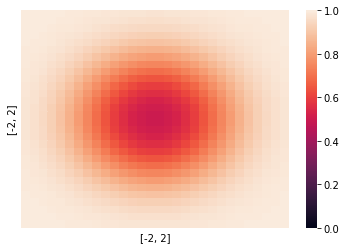

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(data, vmin=0.0, vmax=1.0, xticklabels=False, yticklabels=False)
plt.xlabel(f"[-{d}, {d}]") 
plt.ylabel(f"[-{d}, {d}]") 


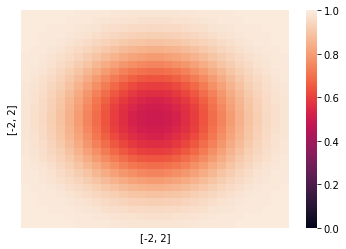

In [72]:
def func(x): 
    return mu_evaluation(model_gr, x[None, :])[-1][-1]
data = np.apply_along_axis(func, -1, X)

import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(data, vmin=0.0, vmax=1.0, xticklabels=False, yticklabels=False)
plt.xlabel(f"[-{d}, {d}]") 
plt.ylabel(f"[-{d}, {d}]") 

model_gr

In [83]:
def func(x): 
    return model_gr.predict(x[None, :])
data = np.apply_along_axis(func, -1, X)

In [84]:
data = np.squeeze(data)

Text(50.0, 0.5, '[-2, 2]')

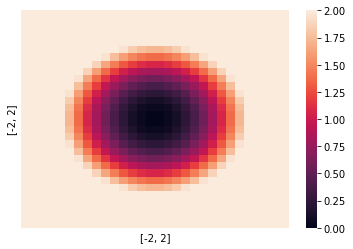

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(data, vmin=0.0, vmax=2.0, xticklabels=False, yticklabels=False)
plt.xlabel(f"[-{d}, {d}]") 
plt.ylabel(f"[-{d}, {d}]") 

Text(50.0, 0.5, '[-2, 2]')

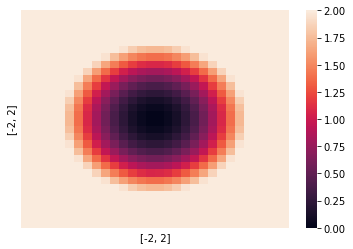

In [86]:
def func(x): 
    return model_no_gr.predict(x[None, :])
data = np.apply_along_axis(func, -1, X)
data = np.squeeze(data)
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(data, vmin=0.0, vmax=2.0, xticklabels=False, yticklabels=False)
plt.xlabel(f"[-{d}, {d}]") 
plt.ylabel(f"[-{d}, {d}]") 